In [4]:
import pandas as pd
import numpy as np
import requests
import json
import re
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import texthero as hero # si pb voir https://stackoverflow.com/questions/68563581/error-while-loading-spacy-e002-cant-find-factory-for-tok2vec et installer spacy v3 (pip install spacy==3.4.1 par ex)
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
#from spellchecker import SpellChecker
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import TruncatedSVD #alternative à PCA pour les matrices creuses
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn import pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
##models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle
import joblib
##pour l'évaluation
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
##pour courbe ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Objectif

Reprise du modèle v1 ML de multi-classification à partir du dataset du MESRI 
- avec la libraire texthero
- en testant une PCA
- en testant sans équilibrer le training set
- en optimisant les hyperparamètres du modèle de ML choisi

## Scopus UCA data

In [ ]:
df_uca = pd.read_csv("../app/bso_publis_scopus/03_primary/publis_uniques_doi_oa_data.csv", sep=",", encoding='utf8')
df_uca.shape

(14545, 35)

## Harvest ministère dataset

url data.gouv (pour les dumps intégraux et voir les datafields) : https://www.data.gouv.fr/fr/datasets/barometre-de-la-science-ouverte/

url sur la plateforme Open data du MESRI (Opendatasoft) : https://data.enseignementsup-recherche.gouv.fr/explore/dataset/open-access-monitor-france/information/?disjunctive.year=&disjunctive.oa_host_type=&flg=fr

id dataset : open-access-monitor-france

url dump csv https://www.data.gouv.fr/fr/datasets/r/c16f65b7-ca4f-409b-be1e-a1482dc2d22a (réponse vide ?)

url dump json : https://www.data.gouv.fr/fr/datasets/r/c79d4a26-6068-4d2a-8272-4df63e0a421d (réponse vide ?)

Alternative : lien .gz sur https://data.enseignementsup-recherche.gouv.fr/explore/dataset/open-access-monitor-france/information/?disjunctive.year=&disjunctive.oa_host_type=&flg=fr

### API (doc)

#### v2

url racine : https://data.enseignementsup-recherche.gouv.fr/api/v2

Voir les infos sur le dataset : https://data.enseignementsup-recherche.gouv.fr/api/v2/catalog/datasets/open-access-monitor-france

#### v1

url racine : https://data.enseignementsup-recherche.gouv.fr/api/v1

Voir les infos sur le dataset (dans la console opnedatasoft) : https://data.enseignementsup-recherche.gouv.fr/api/v1/console/datasets/1.0/open-access-monitor-france

Console opendatasoft (formulaire web requêtage de l'API) : https://data.enseignementsup-recherche.gouv.fr/api/v1/console/records/1.0/search/?dataset=&q=

Exemple de requête

In [ ]:
resp = requests.get("https://data.enseignementsup-recherche.gouv.fr/api/v2/catalog/datasets/open-access-monitor-france").text
data = json.loads(resp)
data

{'dataset': {'attachments': [],
  'data_visible': True,
  'dataset_id': 'open-access-monitor-france',
  'dataset_uid': 'da_x3n7ki',
  'features': ['analyze'],
  'fields': [{'annotations': {'facet': True},
    'description': "Type d'accès - Année de publication",
    'label': 'oa_host_type_year',
    'name': 'oa_host_type_year',
    'type': 'text'},
   {'annotations': {'facet': True},
    'description': "Type d'accès - Année de publication - Discipline",
    'label': 'oa_host_type_year_scientific_field',
    'name': 'oa_host_type_year_scientific_field',
    'type': 'text'},
   {'annotations': {},
    'description': 'URL doi',
    'label': 'doi_url',
    'name': 'doi_url',
    'type': 'text'},
   {'annotations': {},
    'description': "Type d'accès - Type de document",
    'label': 'oa_host_type_genre',
    'name': 'oa_host_type_genre',
    'type': 'text'},
   {'annotations': {},
    'description': "Type d'accès - Editeur",
    'label': 'oa_host_type_publisher',
    'name': 'oa_host_type

### Dump

In [ ]:
df_bso = pd.read_csv('https://storage.gra.cloud.ovh.net/v1/AUTH_32c5d10cb0fe4519b957064a111717e3/bso_dump/bso-publications-latest.csv.gz',compression='gzip',encoding='utf8').convert_dtypes()
df_bso.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,3,4,5,6,11,12,16,17,18,19,20,21,22,23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2867967, 29)

#### Exploration rapide

In [ ]:
df_bso.columns

Index(['doi', 'year', 'title', 'journal_issns', 'journal_issn_l',
       'journal_name', 'publisher', 'publisher_dissemination', 'hal_id',
       'pmid', 'bso_classification', 'bsso_classification', 'domains', 'lang',
       'genre', 'amount_apc_EUR', 'detected_countries',
       'bso_local_affiliations', 'is_oa', 'journal_is_in_doaj',
       'journal_is_oa', 'observation_date', 'oa_host_type', 'oa_colors',
       'licence_publisher', 'licence_repositories', 'repositories',
       'funding_anr', 'funding_europe'],
      dtype='object')

In [ ]:
df_bso[['bso_local_affiliations','amount_apc_EUR']]

,bso_local_affiliations,amount_apc_EUR
0,<NA>,3675.849542
1,<NA>,<NA>
2,<NA>,<NA>
3,<NA>,2982.914375
4,<NA>,<NA>
...,...,...
1550488,200117305K;180070039;130015506;130026024,<NA>
1550489,200117305K;180089047;180070039;130015506;13002...,2340.6
1550490,200117305K;180070039;130015506,354.0
1550491,200117305K;180089047;180070039;130015506,1735.0


In [ ]:
df_bso["bso_local_affiliations"].value_counts()

europe                                                                                       58498
180036048                                                                                    25826
130026081                                                                                    25486
130026024                                                                                    22568
775685019                                                                                    20841
                                                                                             ...  
193509361;180036048;130026081;196917744;180089013;130018351                                      1
europe;130026149;130015332;ANR                                                                   1
193509361;130015332;180036048;130023385;130026081;180070039;130015506;180089013;130018351        1
europe;130026149;197534860;130026081;180089013;130018351                                         1
193509361;

##### Classification (disciplines)

In [ ]:
df_bso.bso_classification.unique()

<StringArray>
[                            'Medical research',
                              'Biology (fond.)',
         'Computer and \n information sciences',
 'Earth, Ecology, \nEnergy and applied biology',
                              'Social sciences',
                                   'Humanities',
                                  'Engineering',
                 'Physical sciences, Astronomy',
                                  'Mathematics',
                                    'Chemistry',
                                      'unknown']
Length: 11, dtype: string

In [ ]:
px.histogram(df_bso.sort_index(), x='bso_classification')

In [ ]:
df_bso[['bso_classification','bsso_classification','domains']].head(20)

,bso_classification,bsso_classification,domains
0,Medical research,Cardiorespiratory Medicine and Haematology;Pha...,health
1,Medical research,Microbiology,health
2,Biology (fond.),Psychology and Cognitive Sciences,health
3,Medical research,Cardiorespiratory Medicine and Haematology;Pub...,health
4,Medical research,Public Health and Health Services,health
5,Medical research,Clinical Sciences,health
6,Medical research,Engineering,health
7,Medical research,Agricultural and Veterinary Sciences,health
8,Medical research,Psychology and Cognitive Sciences,health
9,Medical research,Public Health and Health Services,health


##### Editeurs

In [ ]:
pd.DataFrame({'group':df_bso["publisher_dissemination"].value_counts().nlargest(20).index, 'count':df_bso["publisher_dissemination"].value_counts().nlargest(20).values})

,group,count
0,Elsevier,380119
1,Springer-Nature,164350
2,Wiley,104842
3,OpenEdition,90300
4,IEEE,79491
5,CAIRN,66679
6,Informa,37079
7,Springer,36162
8,Oxford University Press,36116
9,MDPI,35056


In [ ]:
pd.DataFrame({'group':df_bso["publisher"].value_counts().nlargest(20).index, 'count':df_bso["publisher"].value_counts().nlargest(20).values})

,group,count
0,Elsevier BV,373403
1,Springer Science and Business Media LLC,133305
2,Wiley,93068
3,OpenEdition,63777
4,CAIRN,61953
5,IEEE,60017
6,Springer International Publishing,46270
7,Oxford University Press (OUP),35001
8,MDPI AG,34881
9,Informa UK Limited,34548


##### Date de publication

In [ ]:
df_bso.year.value_counts()

2020    192346
2019    183701
2018    179106
2017    168235
2016    164545
2021    159993
2015    149025
2014    147581
2013    146637
2022     59289
2023        17
2025        13
2024         3
2103         1
2088         1
Name: year, dtype: Int64

##### Type de publication

In [ ]:
df_bso.genre.value_counts()

journal-article    1266248
book-chapter        117724
proceedings         104308
other                37472
preprint             15760
book                  8981
Name: genre, dtype: Int64

##### APC

In [ ]:
df_bso[['bso_local_affiliations','amount_apc_EUR']]

,bso_local_affiliations,amount_apc_EUR
0,<NA>,3675.849542
1,<NA>,<NA>
2,<NA>,<NA>
3,<NA>,2982.914375
4,<NA>,<NA>
...,...,...
1550488,200117305K;180070039;130015506;130026024,<NA>
1550489,200117305K;180089047;180070039;130015506;13002...,2340.6
1550490,200117305K;180070039;130015506,354.0
1550491,200117305K;180089047;180070039;130015506,1735.0


Dump de préparation d'un dataset doi-classification-APC pairs pour un éventuel futur enrichissement du dataset UCA (éxexuté avec Google Colab)

In [ ]:
df_bso[['doi','year', 'title','bso_classification','amount_apc_EUR']].to_csv("/content/gdrive/MyDrive/Colab Notebooks/opendata_publications_barometre_mesri/export_bso_doi_classification_apc.csv", index=False, encoding='utf8')

#### Affiliation (et num SIREN)

In [ ]:
df_bso["bso_local_affiliations"].isna().value_counts()

True     962970
False    543473
Name: bso_local_affiliations, dtype: int64

In [ ]:
df_bso["bso_local_affiliations"].value_counts()

europe                                                                                                           58313
180036048                                                                                                        26627
130026081                                                                                                        24930
130026024                                                                                                        21556
775685019                                                                                                        20745
                                                                                                                 ...  
130026149;180089047;197534860;180070039;196917744;193113842                                                          1
198608564;192903466;193509361;130026149;180036048;196917744                                                          1
europe;130026149;130026024;775685019;130018351  

Num SIREN UCA : 130025661

In [ ]:
df_bso.loc[df_bso['bso_local_affiliations'].str.contains("130025661", case=True)]

,doi,year,title,journal_issns,journal_issn_l,journal_name,publisher,publisher_dissemination,hal_id,pmid,...,journal_is_in_doaj,journal_is_oa,observation_date,oa_host_type,oa_colors,licence_publisher,licence_repositories,repositories,funding_anr,funding_europe


##### API SIREN (INSEE)

**Se créer un compte**

**Catalogue des API disponibles : https://api.insee.fr/catalogue/**

**Attention : pour utiliser chaque API il faut d'abord y souscrire pour générer un token**

Un token est valable 1 semaine -> pour le régénérer aller dans Mes applications > cliquer sur bso_uca > bouton Regénérer

#### Exemple appel API SIREN par n° siren

https://api.insee.fr/entreprises/sirene/V3/siren/198608564



##### Enrichir les données avec l'API SIREN

In [ ]:
def get_insee_siren_data(siren):
  url = f"https://api.insee.fr/entreprises/sirene/V3/siren/{siren}"
  payload={}
  headers = {
  'Authorization': 'Bearer ##################', # le token est le string après "Bearer"
  'Cookie': 'INSEE=138986250.20480.0000; pdapimgateway=2907226890.22560.0000'
    }
  try:
    response = requests.request("GET", url, headers=headers, data=payload)
    return json.loads(response.text)['uniteLegale']['periodesUniteLegale'][0]['denominationUniteLegale']
  except:
    pass

#def parse_bso_affiliations_row(row):
#  if ";" in row['bso_local_affiliations']:


In [ ]:
get_insee_siren_data("198608564")

'UNIVERSITE DE POITIERS'

In [ ]:
#test sur qqs publis UCA
list_uca_doi = df_uca.doi.tolist()
df_siren_test = df_bso[df_bso['doi'].isin(list_uca_doi) & df_bso["bso_local_affiliations"].notna()][["doi","bso_local_affiliations"]].sample(10)

In [ ]:
df_siren_test["insee_denomination"] = df_siren_test.apply (lambda row: ";".join([get_insee_siren_data(i) for i in list(row["bso_local_affiliations"].split(";"))]), axis=1)
df_siren_test

,doi,bso_local_affiliations,insee_denomination
1068953,10.1016/j.scitotenv.2017.10.083,130026149,UNIVERSITE PSL
1336955,10.1038/s41540-021-00172-y,180089047;130026081,INSTITUT NATIONAL DE RECHERCHE EN INFORMATIQUE...
1143050,10.1017/jfm.2020.729,180089013,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE
1339785,10.1016/j.artint.2017.08.006,180089047,INSTITUT NATIONAL DE RECHERCHE EN INFORMATIQUE...
1254826,10.1123/jab.2016-0104,130026081;196917744,UNIVERSITE GRENOBLE ALPES;UNIVERSITE CLAUDE BE...
1371553,10.1016/j.quascirev.2020.106523,130023385;180089013,SORBONNE UNIVERSITE;CENTRE NATIONAL DE LA RECH...
1293498,10.1016/j.kint.2018.06.015,180036048,INSTITUT NATIONAL DE LA SANTE ET DE LA RECHERC...
1222165,10.4000/eps.7012,198406852,AVIGNON UNIVERSITE
1338966,10.1016/j.neuroimage.2018.06.029,180089047,INSTITUT NATIONAL DE RECHERCHE EN INFORMATIQUE...
1207393,10.5334/dsj-2020-024,130026149;130026024,UNIVERSITE PSL;UNIVERSITE PARIS-SACLAY


#### Dump filtré pour le modèle de classification

In [ ]:
# on ne prend que les publis > 2015 + celles n'étant pas classifiées Unknown + celles ayant les champs title/journal_name/publisher/year non vides (variables ensuite retenues pour la transformation NLP)
df_bso_filtered = df_bso[(df_bso["year"] > 2015) & (df_bso["genre"] == 'journal-article') & (df_bso["bso_classification"] != "unknown") & (df_bso['title'].notna()) & (df_bso['journal_name'].notna()) & (df_bso['publisher'].notna()) & (df_bso['year'].notna())][["doi","title","year","journal_name","publisher","bso_classification"]]
df_bso_filtered.shape

In [ ]:
df_bso_filtered.to_csv("../app/bso_publis_scopus/05_model_input/bso_mesri_filtered.csv", index=False, encoding='utf8')

## Preparation UCA data

### Publications UCA déjà classifiées

In [ ]:
list_uca_doi = df_uca["doi"].tolist()

In [ ]:
print(f"Part des publis UCA présentes dans le dataset du ministère et pour lesquelles on peut déjà récupérer la bso_classification : {round(len(df_bso[df_bso['doi'].isin(list_uca_doi)]['doi'].tolist()) / df_uca.shape[0] * 100)}%")

Part des publis UCA présentes dans le dataset du ministère et pour lesquelles on peut déjà récupérer la bso_classification : 75%


On prépare un fichier doi-bso_classification sur les seuls doi UCA déjà présents côté mesri, que l'on pourra ensuite merger avec le dataset UCA

In [ ]:
df_uca_mesri_intersection = df_bso[(df_bso['doi'].isin(list_uca_doi)) & (df_bso["bso_classification"] != "unknown")][['doi','bso_classification']]
df_uca_mesri_intersection.shape

(10961, 2)

In [ ]:
df_uca_mesri_intersection.to_csv("/content/gdrive/MyDrive/Machine Learning/opendata_publications_barometre_mesri/doi_uca_classification_part1.csv", index=False, encoding="utf-8")

### Publications restantes pour lesquelles on ne récupère pas la variable bso_classification

Ce dataframe sera donc le jeu de données sur lequel on appliquera le modèle de ML choisi

In [ ]:
df_uca_remaining = df_uca[~df_uca['doi'].isin(df_uca_mesri_intersection['doi'].tolist())][['doi','title','year','journal_name']]
df_uca_remaining.shape

(3584, 4)

## Preparation Mesri dataset : encodage variable cible et traitement NLP

In [ ]:
df_bso_filtered = pd.read_csv("../app/bso_publis_scopus/05_model_input/bso_mesri_filtered.csv", encoding='utf8')

#### [Inutilisé dans un 1er temps] Encoder la variable cible avec la classe LabelBinarizer

Ajout d'une colonne target qui transforme la variable bso_classification en matrice dense sachant que "All classifiers in scikit-learn do multiclass classification out-of-the-box"

Doc : https://scikit-learn.org/stable/modules/preprocessing_targets.html#preprocessing-targets puis https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification

(y compris pour passer d'une matrice sense à une matrice creuse)

### 0_Encoder la variable cible avec la classe LabelEncoder

In [ ]:
labelencoder = LabelEncoder()

In [ ]:
df_bso_filtered['bso_classe_encoded'] = labelencoder.fit_transform(df_bso_filtered['bso_classification'])

In [ ]:
df_bso_filtered.head()

,doi,title,year,journal_name,publisher,bso_classification,bso_classe_encoded
0,10.1001/jama.2016.0278,Association of Admission to Veterans Affairs H...,2016,JAMA,American Medical Association (AMA),Medical research,7
1,10.1016/j.diagmicrobio.2016.04.014,Prospective multicenter surveillance identifie...,2016,Diagnostic Microbiology and Infectious Disease,Elsevier BV,Medical research,7
2,10.1177/0018720816651536,Effects of Epinephrine Auto-Injector Shape and...,2016,Human Factors: The Journal of the Human Factor...,SAGE Publications,Biology (fond.),0
3,10.1016/j.jacc.2016.03.507,Association of Guideline-Based Admission Treat...,2016,Journal of the American College of Cardiology,Elsevier BV,Medical research,7
4,10.1111/1475-6773.12455,"A Randomized, Controlled Trial of a Shared Pan...",2016,Health Services Research,Wiley,Medical research,7


### 1_Nettoyage NLP avec texthero

*Traitements réalisés : replacing NA values with empty spaces, lowercasing all text, removing digits, removing punctuation, removing stopwords, removing whitespace*

In [ ]:
df_bso_filtered["feature"] = df_bso_filtered["title"] + ' '  +  df_bso_filtered["journal_name"] + ' '  +  df_bso_filtered["publisher"]

### 2_Stopwords français + stopwords customisés

On enlève en plus les stopwords français et qqs mots contextuellement non signifiants (journal, review)

In [ ]:
def remove_stopwords_fr(s):
  stop_fr = set(stopwords.words('french') + ['journal','review'])
  retained_words = [word for word in s.split() if word not in (stop_fr)]
  return ' '.join(retained_words)

### 3_Suppression caractères spéciaux

In [ ]:
def remove_special_characters(s):
  pattern = r'[^a-zA-Z]'
  text = re.sub(pattern, ' ', s)
  return text

### 4_Lemmatisation et tokenisation

In [ ]:
from nltk import bigrams
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [ ]:
def lemmatize(r):
  lemmatizer = WordNetLemmatizer()
  words = nltk.word_tokenize(r)
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  return " ".join(lemmatized_words)

### 5_[unused]_Spellchecker

In [ ]:
spell = SpellChecker()
misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])
for word in misspelled:
  print(spell.correction(word))
  print(spell.candidates(word))

happening
{'happening', 'henning', 'penning'}


In [ ]:
def spellcheck(s):
  spell = SpellChecker()
  misspelled = nltk.word_tokenize(s)
  check_spell = [spell.correction(word) for word in misspelled] # not working, 
  # prévoir if... else... genre [spell.correction(word) for word in misspelled if spell.correction(word) else word]
  return " ".join(check_spell)

### 6_Pipeline (sera à appliquer sur le dataset UCA)

In [ ]:
df_bso_filtered['cleaned_feature'] = (
            df_bso_filtered['feature']
            .pipe(hero.clean)
            .apply(remove_stopwords_fr)
            .apply(remove_special_characters)
            .apply(lemmatize)
            #.apply(spellcheck)
   )

### Visualisation

In [ ]:
df_bso_filtered['cleaned_feature'].head(5)

0    association admission veteran affair hospital ...
1    prospective multicenter surveillance identifie...
2    effect epinephrine auto injector shape size hu...
3    association guideline based admission treatmen...
4    randomized controlled trial shared panel manag...
Name: cleaned_feature, dtype: object

In [ ]:
hero.top_words(df_bso_filtered['cleaned_feature'])

elsevier       263051
bv             262927
science        199299
medium         120056
business       102647
                ...  
dubertret           1
audiogramme         1
infertilita         1
sessualita          1
fetzara             1
Name: cleaned_feature, Length: 279122, dtype: int64

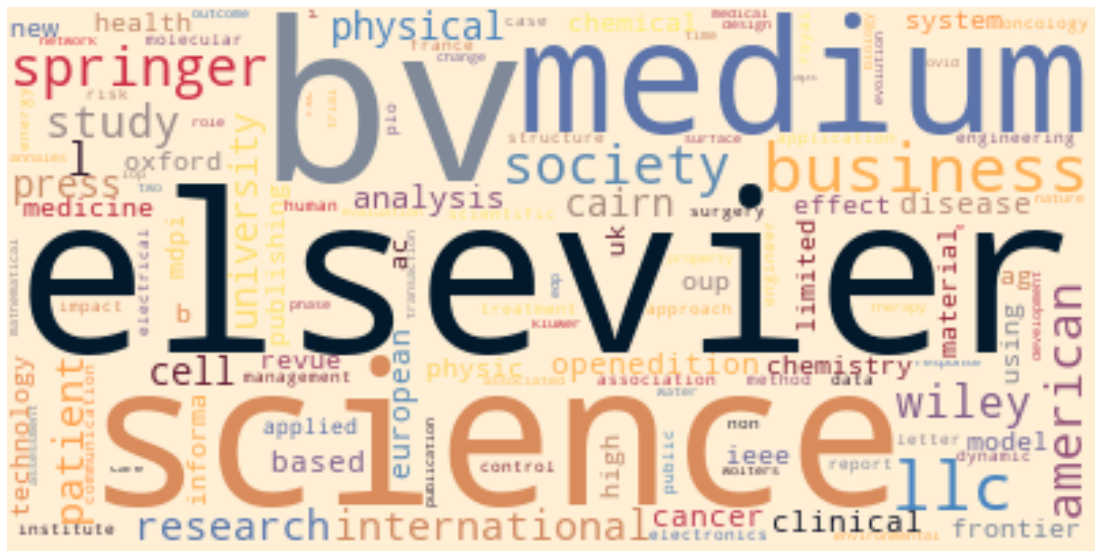

In [ ]:
hero.visualization.wordcloud(df_bso_filtered['cleaned_feature'])

### Sauvegarde

In [ ]:
df_bso_ready = df_bso_filtered[["bso_classification","bso_classe_encoded","doi","cleaned_feature"]]

In [ ]:
df_bso_ready.head(10)

,bso_classification,bso_classe_encoded,doi,cleaned_feature
0,Medical research,7,10.1001/jama.2016.0278,association admission veteran affair hospital ...
1,Medical research,7,10.1016/j.diagmicrobio.2016.04.014,prospective multicenter surveillance identifie...
2,Biology (fond.),0,10.1177/0018720816651536,effect epinephrine auto injector shape size hu...
3,Medical research,7,10.1016/j.jacc.2016.03.507,association guideline based admission treatmen...
4,Medical research,7,10.1111/1475-6773.12455,randomized controlled trial shared panel manag...
5,Medical research,7,10.1373/clinchem.2015.251710,plasma branched chain amino acid incident card...
6,Medical research,7,10.3945/ajcn.115.123448,fto genotype weight loss diet lifestyle interv...
7,Medical research,7,10.1017/s0031182016000640,epidemiological study cantonensis jamaica subs...
8,Medical research,7,10.5664/jcsm.6404,effect manual editing total recording time imp...
9,Medical research,7,10.1093/ntr/ntw334,characteristic american snus swedish snus prod...


In [ ]:
df_bso_ready.to_csv("../app/bso_publis_scopus/05_model_input/mesri_ml_ready.csv", index=False, sep=",", encoding='utf8')

## Train set / test set

In [7]:
df_bso_ready = pd.read_csv("../app/bso_publis_scopus/05_model_input/mesri_ml_ready.csv", sep=",", encoding='utf8',dtype={
                     'bso_classification': str,
                     'bso_classe_encoded': "category",
                     'doi': str,
                     'cleaned_feature': str
                 })

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_bso_ready[["cleaned_feature"]], df_bso_ready[["bso_classe_encoded"]], test_size=0.2, random_state=42)

In [ ]:
X_train

,cleaned_feature
533643,french agrifood co ops head start corporate so...
278872,astrocyte derived jagged mitigates deleterious...
727854,hybrid wave mode formulation vibro acoustic an...
613140,cerebellar transcranial direct current stimula...
298580,lolita deux face fantasme cause desir cairn
...,...
259178,oubli refoulement chez l auteur victime propos...
365838,energy transfer spatially separated entangled ...
131932,global dynamic competition model nonsymmetric ...
671155,end life care icu semper ad meliora always str...


### Text representation + PCA avec texthero

In [ ]:
X_train["tfidf_feature"] = X_train["cleaned_feature"].pipe(hero.tfidf)

In [ ]:
X_train["pca_feature"] = X_train["tfidf_feature"].pipe(hero.pca)

#### Visualisation

In [ ]:
mapping_dict={'0':'Biology (fond.)',
              '1':'Chemistry',
              '2':'Computer and \n information sciences',
              '3':'Earth, Ecology, \nEnergy and applied biology',
              '4':'Engineering',
              '5':'Humanities',
              '6':'Mathematics',
              '7':'Medical research',
              '8':'Physical sciences, Astronomy',
              '9':'Social sciences'}
def to_mapping(row):
    return mapping_dict[row['bso_classe_encoded']]

In [ ]:
training_set = pd.concat([X_train["pca_feature"], y_train], axis=1)
training_set['bso_classification'] = training_set.apply(lambda row: to_mapping(row),axis=1)

In [ ]:
training_set.head(2)

,pca_feature,bso_classe_encoded,bso_classification
391797,"[-0.0292909012551785, -0.03411838831769319]",5,Humanities
758329,"[-0.039079306879749545, -0.020003703299901886]",6,Mathematics


In [ ]:
hero.scatterplot(training_set, 'pca_feature', color='bso_classification', title="PCA BSO classes")

### Equilibrage training set

In [ ]:
px.histogram(y_train.sort_index(), x='bso_classe_encoded')

Output hidden; open in https://colab.research.google.com to view.

In [9]:
rus = RandomUnderSampler(random_state=42, replacement=False)
X_train_miss, y_train_miss = rus.fit_resample(X_train, y_train)

print(f"Training target statistics: {Counter(y_train_miss['bso_classe_encoded'])}")
print(f"Testing target statistics: {Counter(y_test['bso_classe_encoded'])}")

Training target statistics: Counter({'0': 17879, '1': 17879, '2': 17879, '3': 17879, '4': 17879, '5': 17879, '6': 17879, '7': 17879, '8': 17879, '9': 17879})
Testing target statistics: Counter({'7': 66232, '0': 28463, '8': 22187, '3': 15449, '5': 12533, '9': 10438, '1': 9091, '2': 7588, '4': 4992, '6': 4402})


### Fit model classique

In [ ]:
# perform tfidf
tfidf = TfidfVectorizer()
X_train_miss = tfidf.fit_transform(X_train_miss["cleaned_feature"])
X_test = tfidf.transform(X_test["cleaned_feature"])

In [ ]:
# perform pca
# Alternative PCA : see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
svd = TruncatedSVD(n_components=2, random_state=42)
X_train_miss = svd.fit_transform(X_train_miss)
X_test = svd.transform(X_test)

##### Exemple avec modèle de forêts aléatoires sans pipeline et sur training set équilibré

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_miss, y_train_miss.values.ravel())

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test,y_pred)

0.4773259820813232

##### Exemple avec modèle de régression logistique avec pipeline et training set imbalanced

In [ ]:
#[Unsused] Custom classe qui transforme un matrice creuse en matrice dense (l'algo de PCA ne prend que des matrices denses en entrée)
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
         ('tfidf', TfidfVectorizer(), 'cleaned_feature'), #TfidfVectorizer accepts column name only between quotes
    ],
 )
pipe = pipeline.Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        #('to_dense', DenseTransformer()),
        #('pca', PCA(n_components=2)),
        ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)),
     ],
 )
pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'cleaned_feature')])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test,y_pred)

0.8537064093728464

Après plusieurs tests du pipeline, il semblerait que 
- la réduction de dimension par PCA (ou équivalent TruncatedSVD) fasse chuter le score de l'algo -> on ne pratique pas de PCA
- le fait d'adapter le modèle au training set imbalanced fasse augmenter le score (mais peut-être surapprentissage) -> on entraine le modèle sur le training dataset équilibré

## Modèles & prédictions

In [ ]:
def print_confusion_matrix(model,y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f"CONFUSION MATRIX - {model}\n", size=16)


### Automatisation avec plusieurs modèles

None
None
None
None


,model_name,accuracy
0,"(ColumnTransformer(transformers=[('tfidf', Tfi...",0.620471
0,"(ColumnTransformer(transformers=[('tfidf', Tfi...",0.817246
0,"(ColumnTransformer(transformers=[('tfidf', Tfi...",0.762343
0,"(ColumnTransformer(transformers=[('tfidf', Tfi...",0.816695


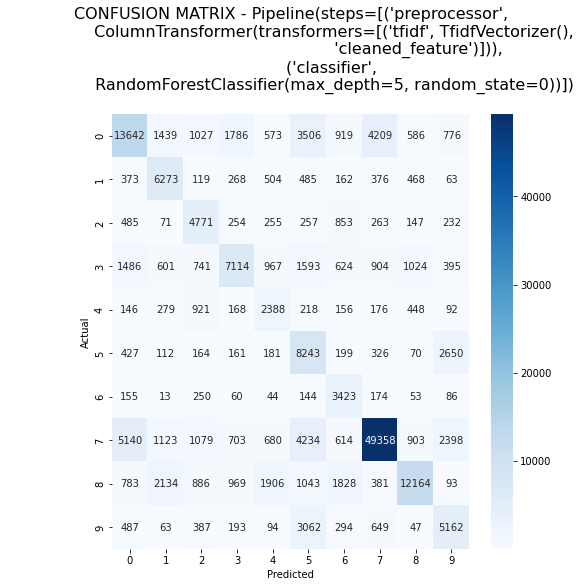

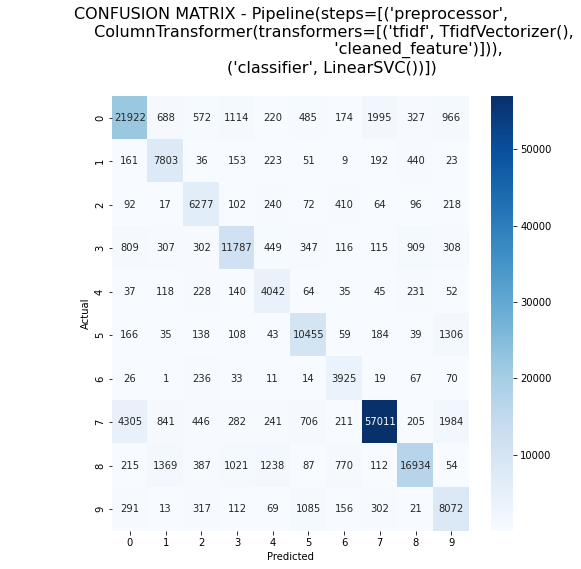

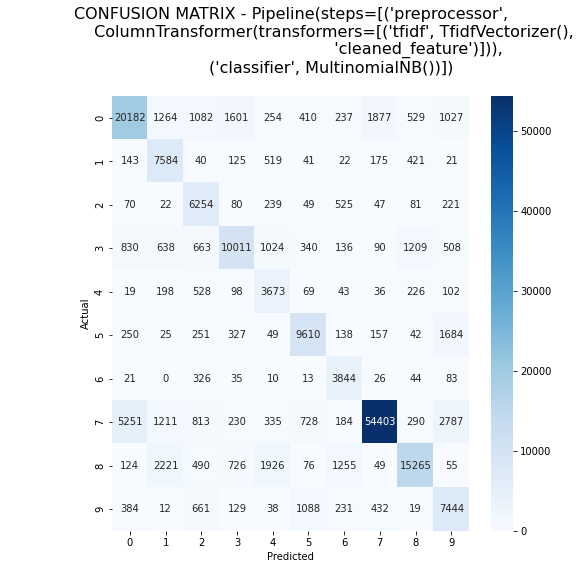

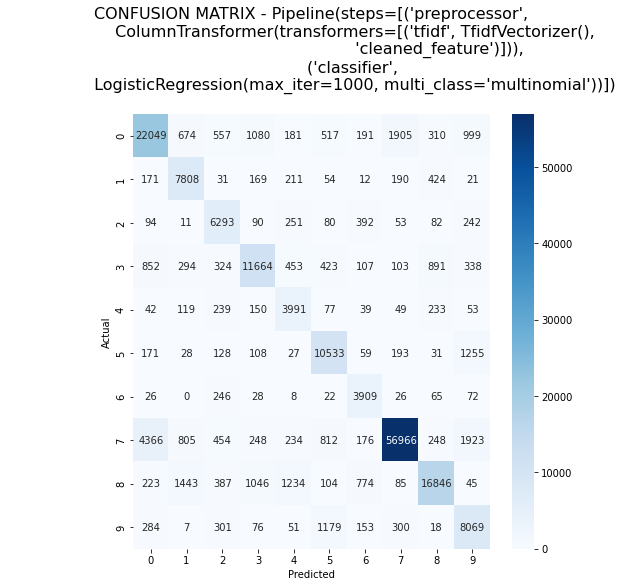

In [ ]:
df_result = pd.DataFrame(columns=['model_name', 'accuracy'])
classifiers = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000),
]

for classifier  in classifiers:
  preprocessor = ColumnTransformer(
    transformers=[
         ('tfidf', TfidfVectorizer(), 'cleaned_feature'), #TfidfVectorizer accepts column name only between quotes
    ],
    )
  pipe = pipeline.Pipeline(
      steps=[
        ('preprocessor', preprocessor),
        #('pca', TruncatedSVD(n_components=5, random_state=42)),
        ('classifier', classifier),
     ],
    )
  model = pipe.fit(X_train_miss, y_train_miss.values.ravel())
  y_pred = model.predict(X_test)
  accuracy = metrics.accuracy_score(y_test,y_pred)
  print(print_confusion_matrix(model,y_pred))
  df_result = df_result.append([{"model_name" : model, "accuracy" : accuracy}])

df_result

### Tuning des hyperparamètres sur LogisticRegression (meilleur score)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
         ('tfidf', TfidfVectorizer(), 'cleaned_feature'),
    ],
 )
gs_pipe = pipeline.Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000)),
     ],
 )

solver_options = ['newton-cg', 'lbfgs', 'sag']
multi_class_options = ['ovr', 'multinomial']
penalty = ['l1','l2']
C = np.linspace(0.1,1.0,num=5)
param_grid = {'classifier__solver': solver_options, 'classifier__multi_class': multi_class_options, 'classifier__C': C, 'classifier__penalty': penalty}

gs = GridSearchCV(gs_pipe,
                  param_grid,
                  cv=3,
                  n_jobs=-1,
                  scoring='accuracy')
gs_result = gs.fit(X_train_miss, y_train_miss.values.ravel())
print("Best: %f using %s" % (gs_result.best_score_, gs_result.best_params_))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pac

Best: 0.803339 using {'classifier__C': 1.0, 'classifier__multi_class': 'multinomial', 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


### Sauvegarde du modèle

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
         ('tfidf', TfidfVectorizer(), 'cleaned_feature'),
    ],
 )
pipe = pipeline.Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(multi_class='multinomial', solver='newton-cg', C=1.0, penalty='l2', max_iter=1000)),
     ],
 )
logmodel = pipe.fit(X_train_miss, y_train_miss.values.ravel())
y_pred = logmodel.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78     28463
           1       0.70      0.86      0.77      9091
           2       0.70      0.83      0.76      7588
           3       0.80      0.76      0.77     15449
           4       0.60      0.80      0.69      4992
           5       0.76      0.84      0.80     12533
           6       0.67      0.89      0.77      4402
           7       0.95      0.86      0.90     66232
           8       0.88      0.76      0.82     22187
           9       0.62      0.77      0.69     10438

    accuracy                           0.82    181375
   macro avg       0.75      0.81      0.77    181375
weighted avg       0.83      0.82      0.82    181375



In [ ]:
joblib.dump(logmodel, '../app/bso_publis_scopus/06_models/logmodel.joblib')

['/content/gdrive/MyDrive/Machine Learning/opendata_publications_barometre_mesri/models/logmodel_v2.joblib']

### Usage

In [13]:
logmodel = joblib.load('../app/bso_publis_scopus/06_models/logmodel.joblib')

In [23]:
logmodel.predict(pd.DataFrame(data={'cleaned_feature': ["law norm experimental evidence liability rule"]}))

array(['9'], dtype=object)

In [21]:
predicted_example = logmodel.predict(X_test)
predicted_example

array(['9', '1', '8', ..., '5', '9', '3'], dtype=object)

## Docs, références

https://www.analyticsvidhya.com/blog/2021/11/introduction-to-automated-multi-class-text-classification/

https://www.kaggle.com/code/selener/multi-class-text-classification-tfidf/notebook

https://towardsdatascience.com/why-you-should-use-scikit-learn-pipelines-8754b4d1e375

https://refactored.ai/microcourse/notebook?path=content%2F06-Classification_models_in_Machine_Learning%2F02-Multivariate_Logistic_Regression%2Fmulticlass_logistic-regression.ipynb

https://towardsdatascience.com/texthero-text-preprocessing-representation-and-visualization-for-a-pandas-dataframe-525405af16b6

https://towardsdatascience.com/your-dataset-is-imbalanced-do-nothing-abf6a0049813